# CLIP Embeddings

In [1]:
import torch
import transformers
from transformers import AutoProcessor, AutoTokenizer, CLIPModel


In [2]:
import PIL.Image
from pathlib import Path
import os
path = Path(".") / "data"

def load_images(path):
  filenames = os.listdir(path) #  The list is in arbitrary order
  # display(filenames)
  filelist = sorted(path.iterdir()) # should be sorted by name, ascending
  display(filelist)
  data = [ PIL.Image.open(p) for p in filelist]
  # display(data)
  return data

images = load_images(path)

[PosixPath('data/Screenshot_2024-03-13_14-43-18.png'),
 PosixPath('data/Screenshot_2024-03-13_14-43-46.png'),
 PosixPath('data/Screenshot_2024-03-13_14-44-01.png'),
 PosixPath('data/Screenshot_2024-03-13_14-44-13.png'),
 PosixPath('data/Screenshot_2024-03-13_14-44-26.png'),
 PosixPath('data/Screenshot_2024-03-13_14-44-37.png'),
 PosixPath('data/Screenshot_2024-03-13_14-44-49.png'),
 PosixPath('data/Screenshot_2024-03-13_14-45-04.png'),
 PosixPath('data/Screenshot_2024-03-13_14-45-15.png'),
 PosixPath('data/Screenshot_2024-03-13_14-45-27.png'),
 PosixPath('data/Screenshot_2024-03-13_14-45-43.png'),
 PosixPath('data/Screenshot_2024-03-13_14-45-55.png'),
 PosixPath('data/Screenshot_2024-03-13_14-46-07.png'),
 PosixPath('data/Screenshot_2024-03-13_14-46-18.png'),
 PosixPath('data/Screenshot_2024-03-13_14-46-28.png'),
 PosixPath('data/Screenshot_2024-03-13_14-46-38.png'),
 PosixPath('data/Screenshot_2024-03-13_14-46-50.png'),
 PosixPath('data/Screenshot_2024-03-13_14-47-00.png'),
 PosixPath

In [3]:
# images

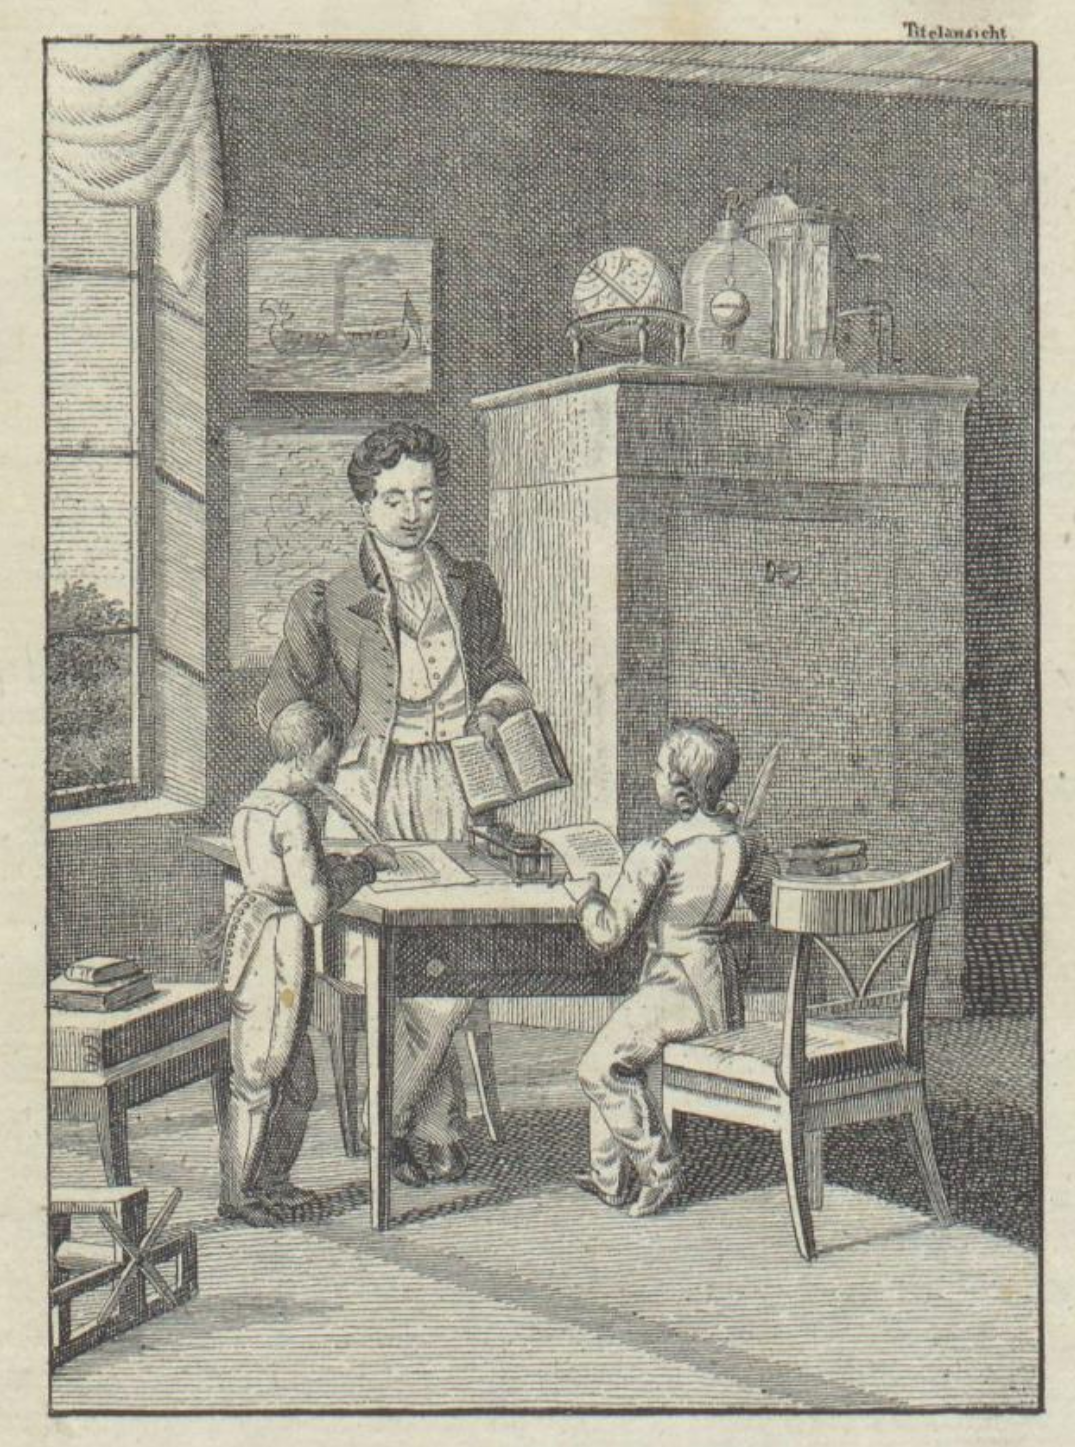

In [4]:
images[0]


In [5]:
# images[1]

# Loading the CLIP Model

https://github.com/LAION-AI
https://laion.ai/

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
modelURI = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(modelURI).to(device)
processor = AutoProcessor.from_pretrained(modelURI)
tokenizer = AutoTokenizer.from_pretrained(modelURI)

In [9]:
# model

Get the embeddings for our sample

In [10]:
with torch.no_grad():
  inputs = processor(images=images, return_tensors="pt").to(device)
  image_embedding = model.get_image_features(**inputs)
  

In [11]:
image_embedding.shape

torch.Size([27, 512])

Calculate similarity between images

In [12]:
ien = image_embedding / image_embedding.norm(p=2, dim=1, keepdim=True)
similarity = ien @ ien.transpose(0, 1)

In [13]:
import matplotlib.pyplot as plt
# plt.imshow(similarity.cpu().detach())

In [14]:
# similarity.argsort(dim=-1, descending=True)

In [15]:
pairs = similarity.argsort(dim=-1, descending=True)[:,1:3]
i=4
# fig, axs = plt.subplot_mosaic([["A", "B"]])
# axs["A"].imshow(images[pairs[i][0]])
# axs["B"].imshow(images[pairs[i][1]])

In [16]:
prompts = ["image contains ornament consisting of plants", 
           "image contains ornament consisting of animals", 
           "image contains ornament consisting of abstract geometrical shapes",
           "image contains ornament consisting of simple lines",
           "image contains ornament consisting of banners or arches",
           "image contains ornament consisting of letters or words",
           "image does not contain ornament"]

with torch.no_grad():
  inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)
  text_embeddings = model.get_text_features(**inputs)

In [17]:
# text_embeddings.shape

In [18]:
import torch
with torch.no_grad():
  inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)
  text_embeddings = model.get_text_features(**inputs)
  ien = image_embedding / image_embedding.norm(p=2, dim=1, keepdim=True)
  ten = text_embeddings / text_embeddings.norm(p=2, dim=1, keepdim=True)
  r = (ien @ ten.transpose(0, 1)).cpu().detach()
  

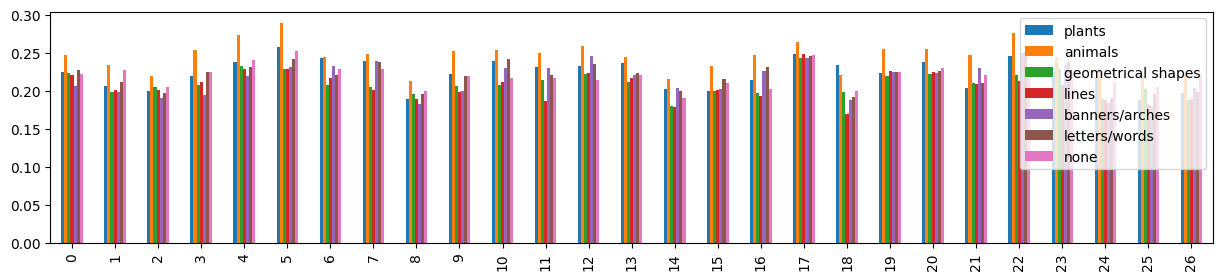

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame( r, columns=["plants", "animals", "geometrical shapes", "lines", "banners/arches", "letters/words", "none"])
df.plot(kind="bar", figsize=(15,3))
plt.legend()

In [20]:
def zeroshot_classification(prompts):
  with torch.no_grad():
    inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)
    text_embeddings = model.get_text_features(**inputs)
    ien = image_embedding / image_embedding.norm(p=2, dim=1, keepdim=True)
    ten = text_embeddings / text_embeddings.norm(p=2, dim=1, keepdim=True)
    r = (ien @ ten.transpose(0, 1)).softmax(-1)
  return r.argmax(-1).cpu().detach().tolist()

In [21]:
prompts = ["this illustration has a frame around the actual image", "this illustration has no frame around the actual image"]
cls = zeroshot_classification(prompts)
classes = ["frame", "no frame"]
cls=[classes[c] for c in cls]
cls

['no frame',
 'no frame',
 'no frame',
 'no frame',
 'no frame',
 'no frame',
 'no frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'no frame',
 'frame',
 'no frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'frame',
 'no frame',
 'frame']

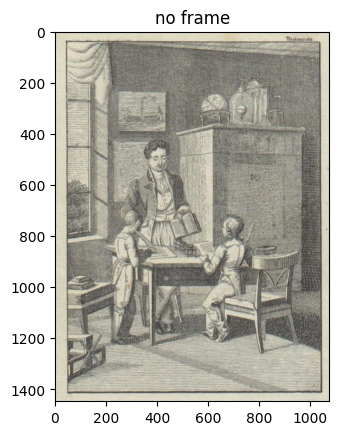

In [22]:
i = 0
plt.title(cls[i])
plt.imshow(images[i])

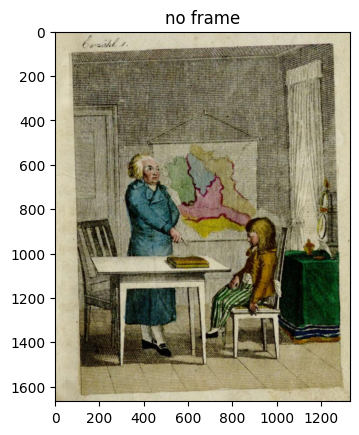

In [23]:
i = 1
plt.title(cls[i])
plt.imshow(images[i])

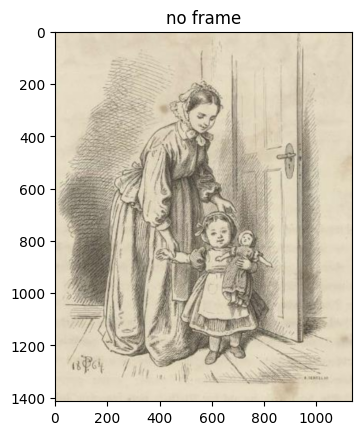

In [24]:
i = 2
plt.title(cls[i])
plt.imshow(images[i])

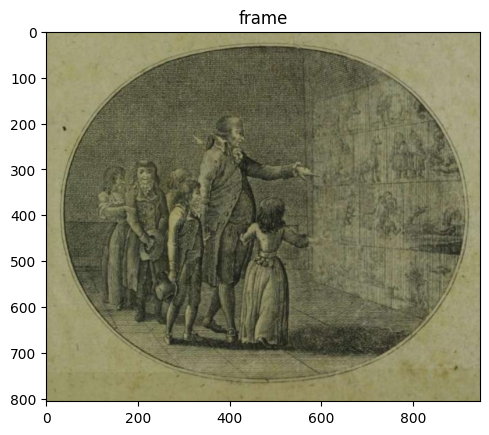

In [25]:
i = 19
plt.title(cls[i])
plt.imshow(images[i])

In [26]:

prompts = ["image contains ornament consisting of plants", 
           "image contains ornament consisting of animals", 
           "image contains ornament consisting of abstract geometrical shapes",
           "image contains ornament consisting of simple lines",
           "image contains ornament consisting of banners or arches",
           "image contains ornament consisting of letters or words",
           "image does not contain ornament"]
cls = zeroshot_classification(prompts)
classes = ["plants", "animals", "geometrical shapes", "lines", "banners/arches", "letters/words", "none"]
cls=[classes[c] for c in cls]
cls

['animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'animals',
 'plants',
 'animals',
 'animals']

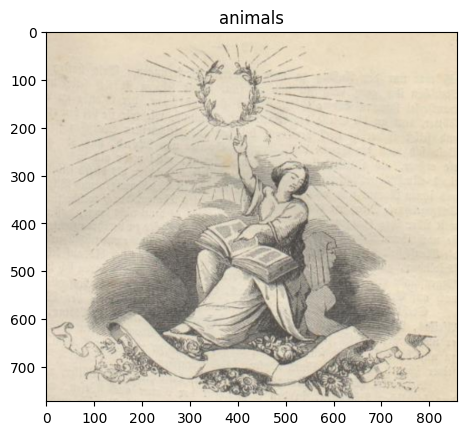

In [28]:
i = 7
plt.title(cls[i])
plt.imshow(images[i])

# Pipelines
https://huggingface.co/tasks/zero-shot-image-classification

In [29]:
from transformers import pipeline
# More models in the model hub.

classifier = pipeline("zero-shot-image-classification", model = modelURI)

In [32]:
labels_for_classification =  ["this image has an ornament", "this image has no ornament"]
scores = classifier(images,
                    candidate_labels = labels_for_classification)

In [33]:
scores

[[{'score': 0.5589383244514465, 'label': 'this image has no ornament'},
  {'score': 0.4410616159439087, 'label': 'this image has an ornament'}],
 [{'score': 0.5791015028953552, 'label': 'this image has no ornament'},
  {'score': 0.4208984673023224, 'label': 'this image has an ornament'}],
 [{'score': 0.7021352648735046, 'label': 'this image has no ornament'},
  {'score': 0.297864705324173, 'label': 'this image has an ornament'}],
 [{'score': 0.6533883213996887, 'label': 'this image has no ornament'},
  {'score': 0.34661170840263367, 'label': 'this image has an ornament'}],
 [{'score': 0.500554084777832, 'label': 'this image has an ornament'},
  {'score': 0.49944591522216797, 'label': 'this image has no ornament'}],
 [{'score': 0.5289412140846252, 'label': 'this image has no ornament'},
  {'score': 0.47105881571769714, 'label': 'this image has an ornament'}],
 [{'score': 0.6456489562988281, 'label': 'this image has no ornament'},
  {'score': 0.3543509840965271, 'label': 'this image has 